# TP6 : Calibration d’un odomètre
### Auteur : ARGUELLO Camilo

### Introduction

Dans ce TP, notre objectif c'est de faire des ajustements de données prises avec un dispositif de mesure de vistesse où on ne connaît pas les grandeurs physiques. Pour cela on va faire des estimations de valeurs attendues, en comparant avec des valeurs moyennes de vitesse connues. Finalement, l'objectif c'est d'indiquer à quel point le dispositif de mesure est bien calibré.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import qexpy as q
import qexpy.plotting as qplt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

### 1. Ajustement d'histogrammes

On a un dataset avec des mesures de calibration d'un odomètre. Pour chacune des mesures on a une vitesse moyenne connue, à l'exception de la mesure `picinconnu`. 

Pour rendre le dataset plus facile à manipuler, on garde les données dans une liste `vitesses` qui contiennent les vitesses moyennes connues, et une liste `mesures` qui contient les mesures de l'odomètre.

In [3]:
# read the files pic1.csv, pic2.csv, pic3.csv
pic1 = pd.read_csv("pic1.csv", skiprows=0)
pic2 = pd.read_csv("pic2.csv", skiprows=0)
pic3 = pd.read_csv("pic3.csv", skiprows=0)
picinconnu = pd.read_csv("pic_inconnu.csv", skiprows=0)

vitesses = np.array([
    { 'pic': pic1, 'vitesse_moy': 13.9 }, 
    { 'pic': pic2, 'vitesse_moy': 19.4 }, 
    { 'pic': pic3, 'vitesse_moy': 36.1 }
])

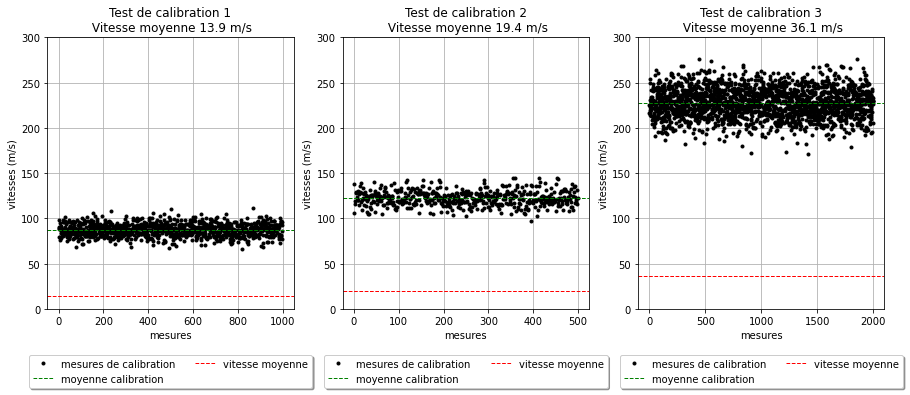

In [4]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, v in enumerate(vitesses):
    ax = axes[i]
    ax.plot(v["pic"]["mesures"], '.', color='black', label='mesures de calibration')
    # plot moyenne des mesures de calibration
    ax.axhline(np.mean(v["pic"]["mesures"]), color='g', linestyle='dashed', linewidth=1, label='moyenne calibration')
    # plot vitesses moyennes
    ax.axhline(v["vitesse_moy"], color='r', linestyle='dashed', linewidth=1, label='vitesse moyenne')
    ax.set_xlabel('mesures')
    ax.set_ylabel('vitesses (m/s)')
    ax.set_title('Test de calibration '+str(i+1)+'\n Vitesse moyenne ' + str(v["vitesse_moy"]) + ' m/s')
    ax.grid(True)
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), shadow=True, ncol=2)
    ax.set_ylim(0, 300) # on limite l'axe des y pour mieux voir les points
plt.show()

In [5]:
diff = [np.round(np.abs(v["vitesse_moy"] - np.mean(v["pic"]["mesures"])),2) for v in vitesses]
print("Différences entre la vitesse moyenne et la moyenne des mesures de calibration: ", diff)

Différences entre la vitesse moyenne et la moyenne des mesures de calibration:  [73.5, 103.02, 191.36]


Pour comprendre la structure des données, on fait un graphique qui vérifie de manière visuelle la distribution possible des données. Ceci est très utile pour pouvoir comprendre la dimension et le possible grandeur des données. Et plus tard vérifier à l'aide d'un histogramme. Cette observation montre que la différence entre la valeur moyenne et la valeur médiane de la vitesse est de `73.5` pour la calibration 1, de `103.02` pour la calibration 2 et de `191.36` pour la calibration 3. Il peut s'agir d'un premier indicateur de la qualité de la calibration du dispositif.

Nous validons l'information à l'aide d'un histogramme.

Pic de calibration 1: 8.7e+01
Pic de calibration 2: 1.3e+02
Pic de calibration 3: 2.3e+02


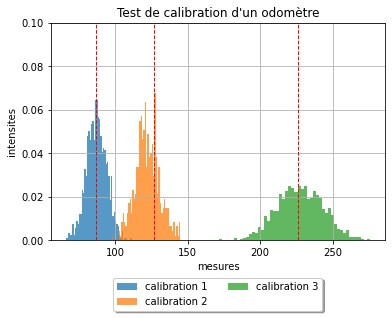

In [6]:
for i, v in enumerate(vitesses):
    n, bins, patches = plt.hist(v["pic"]["mesures"], 50, density=True, alpha=0.75, label='calibration ' + str(i+1))
    index = np.argmax(n)
    print("Pic de calibration " + str(i+1) + ": {:.2}".format(bins[index]))
    plt.axvline(bins[index], color='r', linestyle='dashed', linewidth=1)
    plt.xlabel('mesures')
    plt.ylabel('intensites')
    plt.title('Test de calibration d\'un odomètre')
    plt.grid(True)
    plt.ylim(0, .1)
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), shadow=True, ncol=2)
plt.show()

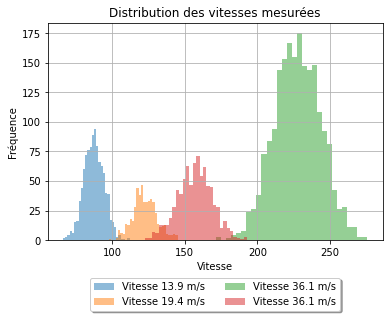

In [10]:
# Lecture des données à partir des fichiers CSV
pic1_data = pd.read_csv('pic1.csv')
pic2_data = pd.read_csv('pic2.csv')
pic3_data = pd.read_csv('pic3.csv')
pic_inconnu_data = pd.read_csv('pic_inconnu.csv')

# Extraction des valeurs de vitesse
pic1_speed = pic1_data['mesures']
pic2_speed = pic2_data['mesures']
pic3_speed = pic3_data['mesures']
pic_inconnu_speed = pic_inconnu_data['mesures']

# Tracé des histogrammes
plt.hist(pic1_speed, bins=30, alpha=0.5, label='Vitesse 13.9 m/s')
plt.hist(pic2_speed, bins=30, alpha=0.5, label='Vitesse 19.4 m/s')
plt.hist(pic3_speed, bins=30, alpha=0.5, label='Vitesse 36.1 m/s')
plt.hist(pic_inconnu_speed, bins=30, alpha=0.5, label='Vitesse 36.1 m/s')

plt.xlabel('Vitesse')
plt.ylabel('Fréquence')
plt.title('Distribution des vitesses mesurées')
plt.grid(True)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), shadow=True, ncol=2)
plt.show()

Il s'agit de trois distributions **gaussiennes** dont les pics sont à `8.7e1`, `1.3e2` et `2.3e2`. On voit que les paramètres qui nous intéressent sont **les pics** et **la dispersion des valeurs**. Par exemple, la mesure de calibration 1 et calibration 2, visuellement, n'ont pas une grande dispersion, comparés aux mesures de calibration 3. Ces valeurs seront vérifiées dans la section suivante.

### 1.2 Estimation de la moyenne


#### Mesure de la moyenne statistique

In [7]:
# add pic inconnu to the array of vitesses
vitesses = np.append(vitesses, [{ 'pic': picinconnu, 'vitesse_moy': None }])

In [8]:
## Mesure de la moyenne statistique

moyennes_statistique = list()
ecart_types_statistique = list()
erreurs_statistique = list()
erreurs_relatives = list()
# Calcul des moyennes et des écarts-types
for i, v in enumerate(vitesses):
    moyenne = np.mean(v["pic"]["mesures"])
    ecart_type = np.std(v["pic"]["mesures"])
    erreur = ecart_type / np.sqrt(len(v["pic"]["mesures"])) # erreur sur la moyenne = ecart-type / sqrt(n)

    if (v["vitesse_moy"] == None):
        erreur_relative = np.inf # On met une erreur relative infinie car on connait pas la vitesse réelle
    else:
        # erreur relative = |valeur mesurée - valeur réelle| / valeur réelle
        erreur_relative = np.abs(moyenne - v["vitesse_moy"]) / v["vitesse_moy"]

    moyennes_statistique.append(moyenne)
    ecart_types_statistique.append(ecart_type)
    erreurs_statistique.append(erreur)
    erreurs_relatives.append(erreur_relative)

# get min errerus_relatives
min_erreur_relative = np.min(erreurs_relatives)
# get index of min erreur_relative
index_min_erreur_relative = erreurs_relatives.index(min_erreur_relative)
# get moyenne with min erreur_relative
moyenne_min_erreur_relative = moyennes_statistique[index_min_erreur_relative]

print('L\'erreur relative minimale est: {:.2%}'.format(min_erreur_relative))
print('Le pic de la calibration ' + str(index_min_erreur_relative+1) + ' a la moyenne plus proche de la vitesse moyenne est: {:.3}'.format(moyenne_min_erreur_relative))

L'erreur relative minimale est: 528.81%
Le pic de la calibration 1 a la moyenne plus proche de la vitesse moyenne est: 87.4


#### Ajustement des données avec `QExPy`

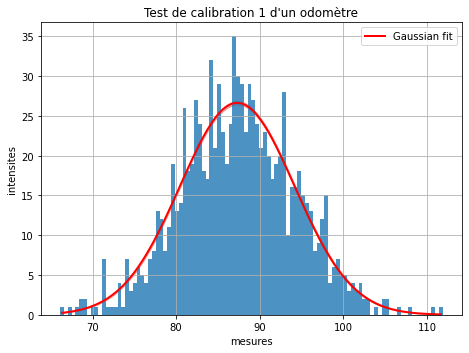

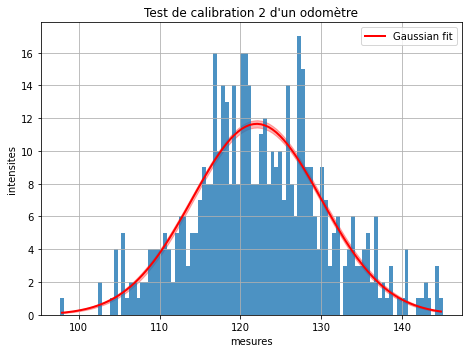

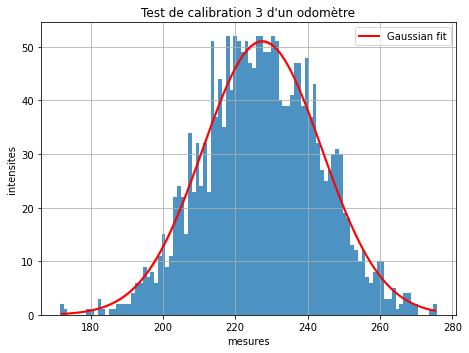

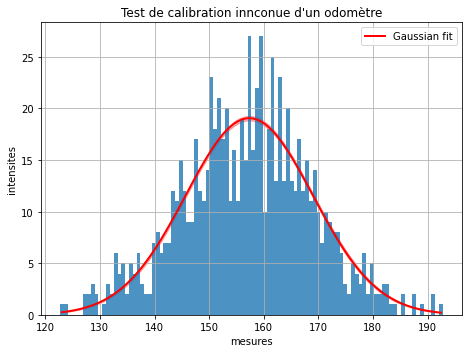

In [8]:
results_qexpy = list()

for i, v in enumerate(vitesses):
    vitesse = np.array(v["pic"]["mesures"])
    n, bins, figure = qplt.hist(vitesse, bins=100)
    result = figure.fit(model=q.FitModel.GAUSSIAN, parguess=[np.max(vitesse), np.mean(vitesse), np.std(vitesse)], color='r', label='Gaussian fit')
    results_qexpy.append(result)
    figure.legend()
    if v["vitesse_moy"] == None:
        figure.title = 'Test de calibration innconue d\'un odomètre'
    else:
        figure.title = 'Test de calibration '+ str(i+1) +' d\'un odomètre'
    figure.xname = 'mesures'
    figure.yname = 'intensites'
    figure.show()

In [9]:
# On récupère les paramètres des gaussiennes
# Les paramètres récupérés sont dans l'ordre: amplitude, moyenne, écart-type
params = [result.params for result in results_qexpy]
qexpy_values = [p.value for param in params for p in param]
qexpy_incertitudes = [p.error for param in params for p in param]

#reshape values to 4x3 matrix (4 gaussians, 3 parameters)
qexpy_values = np.reshape(qexpy_values, (4, 3))
moyennes_qexpy = qexpy_values[:,1]
ecart_types_qexpy = qexpy_values[:,2]

corr_matrix = np.corrcoef(qexpy_values)

print(corr_matrix)

[[1.         0.93466855 0.99710443 0.99570784]
 [0.93466855 1.         0.90492681 0.96356098]
 [0.99710443 0.90492681 1.         0.98578662]
 [0.99570784 0.96356098 0.98578662 1.        ]]


#### Comparaison des résultats

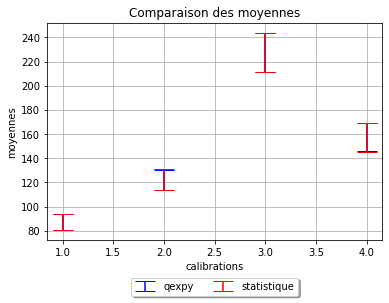

In [10]:

calibration = np.arange(1, 5) # 4 calibrations
# plot error bars
plt.errorbar(calibration, moyennes_qexpy, yerr=ecart_types_qexpy, fmt = 'none', capsize = 10, ecolor = 'blue', label='qexpy')
plt.errorbar(calibration, moyennes_statistique, yerr=ecart_types_statistique, fmt = 'none', capsize = 10, ecolor = 'red', label='statistique')
plt.xlabel('calibrations')
plt.ylabel('moyennes')
plt.title('Comparaison des moyennes')
plt.grid(True)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), shadow=True, ncol=2)
plt.show()


In [11]:
#vitesses = np.append(vitesses, [{ 'pic': picinconnu, 'vitesse_moy': None, 'moyenne': np.mean(moyennes), 'ecart_type': np.std(moyennes), 'erreur': np.std(moyennes) / np.sqrt(len(moyennes)) }])

#### 1.3 Détermination des paramètres de la calibration

Coefficients: [0.15839623]
Intercept: 0.07269223596440355


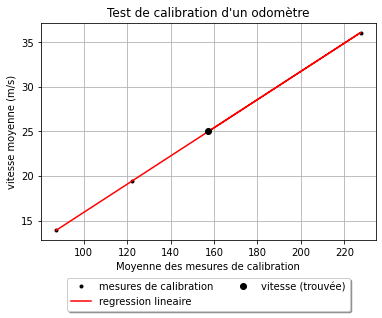

In [12]:
# 1.3 Détermination des paramètres de la calibration

x = np.array([moyennes_qexpy[i] for i,v in enumerate(vitesses) if v['vitesse_moy'] is not None]).reshape(-1, 1)
y = np.array([v['vitesse_moy'] for v in vitesses if v['vitesse_moy'] is not None])

# Fit a linear regression model
model = LinearRegression()
model.fit(x, y)

# On récupère les paramètres des gaussiennes
# Ici x_pred correspond aux moyennes des gaussiennes et y_pred à la vitesse moyenne manquante
x_pred = np.array([moyennes_qexpy[i] for i,v in enumerate(vitesses)]).reshape(-1, 1)
y_pred = model.predict(x_pred)

print("Coefficients:", model.coef_)
print("Intercept:", model.intercept_)

plt.plot(x, y, '.', color='black', label='mesures de calibration')
plt.plot(x_pred, y_pred,  color='red', label='regression lineaire')

# add a point for the unknown speed
plt.plot(x_pred[3], y_pred[3], 'o', color='black', label='vitesse (trouvée)')

plt.xlabel('Moyenne des mesures de calibration')
plt.ylabel('vitesse moyenne (m/s)')
plt.title('Test de calibration d\'un odomètre')
plt.grid(True)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), shadow=True, ncol=2)
plt.show()


In [13]:
# 1.4 Calibration en énergie d'un pic

# On remplace les valeurs manquantes par les valeurs prédites
for i, v in enumerate(vitesses):
    if v['vitesse_moy'] is None:
        v['vitesse_moy'] = y_pred[i]


In [14]:
def calculate_uncertainty (mesures):
    """
    Cette fonction calcule l'incertitude sur la moyenne d'une série de mesures
    """
    avg = np.mean(mesures)
    std = np.std(mesures) 
    dx = std / np.sqrt(len(mesures))
    d = np.sqrt(dx**2 + dx**2)
    return avg, d

In [15]:
# get moyennes and incertitudes
vitesses_moy = np.array([v['vitesse_moy'] for v in vitesses]) # m/s
avg_vitesses_moy, delta_vitesses_moy = calculate_uncertainty(vitesses_moy) # m/s

# convert to km/h
avg_vitesses_moy_h = avg_vitesses_moy * 3.6
delta_vitesses_moy_h = delta_vitesses_moy * 3.6

print('Vitesse trouvée = {:.3} km/h ± {:.2} km/h'.format(avg_vitesses_moy_h, delta_vitesses_moy_h))


Vitesse trouvée = 85.0 km/h ± 2.1e+01 km/h
